# Дерева рішень. Регресія. Баланс кредитної карти

Прикладне математичне моделювання в R

---

У даній частині навчального процесу потрібно побудувати математичні моделі регресії клієнтів на основі алгоритму дерева рішень та перевірити їх на тестовій вибірці.

## Підготовка

In [1]:
# install.packages("DMwR")
# install.packages("gmodels")
# install.packages("rpart")
# install.packages("partykit")
# install.packages("rpart.plot")
# install.packages("RColorBrewer")
# install.packages("rattle")

In [2]:
Sys.setlocale("LC_CTYPE", "ukrainian") 
options(warn = -1)

[1] "Ukrainian_Ukraine.1251"

Джерела:

- [x] An Introduction to Statistical Learning with Applications in R <http://www-bcf.usc.edu/~gareth/ISL/data.html>
- [x] Predicting Credit Card Balance using Regression <https://www.kaggle.com/suzanaiacob/predicting-credit-card-balance-using-regression/notebook>

Для виконнання завдань потрібний ряд R-пакетів: 

In [1]:
suppressMessages(library(ggplot2)) # побудова графіків
suppressMessages(library(gmodels)) # побудова крос-таблиць
suppressMessages(library(rpart)) # дерево рішень
suppressMessages(library(partykit)) # дерево рішень
suppressMessages(library(rpart.plot)) # візуалізація дерева рішень
suppressMessages(library(DMwR)) # оцінка похибок моделі
suppressMessages(library(rattle)) # допомога у візуалізації 
suppressMessages(library(RColorBrewer)) # допомога у візуалізації 

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

Якщо ці пакети відсутні, то інсталюйте їх за допомогою команди `install.packages(назва_пакету)`.

Для очистки сесії від непотрібних даних використайте команду `rm()`:

```r
rm(list = ls()) #видаляє усі змінні
```

## Набір даних

Дані складають з 400 спостежень та наступник пкоазників:

- [x] `ID` - ідентифікатор;
- [x] `Income` - дохід у $10,0000;
- [x] `Limit` - кредитний ліміт;
- [x] `Rating` - кредитний рейтинг;
- [x] `Age` - вік, роки;
- [x] `Education` - освіта, кількість років навчання;
- [x] `Gender` - стать (Male or Female);
- [x] `Student` - флаг чи є студентом (Yes or No);
- [x] `Married` - флаг чи одружений (Yes or No);
- [x] `Ethnicity` - етнічна належність (African American, Asian or Caucasian);
- [x] `Balance` - середній баланс по карті у $$.

Задача: **визначити вплив факторів на середній баланс по карті.**


Імпорт даних:

In [1]:
data <- read.csv("data/credit_card_balance.csv")

Переглянемо структуру даних:

In [25]:
str(data)

'data.frame':	400 obs. of  11 variables:
 $ Income   : num  14.9 106 104.6 148.9 55.9 ...
 $ Limit    : int  3606 6645 7075 9504 4897 8047 3388 7114 3300 6819 ...
 $ Rating   : int  283 483 514 681 357 569 259 512 266 491 ...
 $ Cards    : int  2 3 4 3 2 4 2 2 5 3 ...
 $ Age      : int  34 82 71 36 68 77 37 87 66 41 ...
 $ Education: int  11 15 11 11 16 10 12 9 13 19 ...
 $ Gender   : Factor w/ 2 levels "Female","Male": 2 1 2 1 2 2 1 2 1 1 ...
 $ Student  : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 1 1 1 1 2 ...
 $ Married  : Factor w/ 2 levels "No","Yes": 2 2 1 1 2 1 1 1 1 2 ...
 $ Ethnicity: Factor w/ 3 levels "African American",..: 3 2 2 2 3 3 1 2 3 1 ...
 $ Balance  : int  333 903 580 964 331 1151 203 872 279 1350 ...


In [26]:
anyNA(data)

[1] FALSE

In [3]:
head(data)

,X,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151


Оглянемо описову статистику факторів:

In [4]:
summary(data)

       X             Income           Limit           Rating     
 Min.   :  1.0   Min.   : 10.35   Min.   :  855   Min.   : 93.0  
 1st Qu.:100.8   1st Qu.: 21.01   1st Qu.: 3088   1st Qu.:247.2  
 Median :200.5   Median : 33.12   Median : 4622   Median :344.0  
 Mean   :200.5   Mean   : 45.22   Mean   : 4736   Mean   :354.9  
 3rd Qu.:300.2   3rd Qu.: 57.47   3rd Qu.: 5873   3rd Qu.:437.2  
 Max.   :400.0   Max.   :186.63   Max.   :13913   Max.   :982.0  
     Cards            Age          Education        Gender         
 Min.   :1.000   Min.   :23.00   Min.   : 5.00   Length:400        
 1st Qu.:2.000   1st Qu.:41.75   1st Qu.:11.00   Class :character  
 Median :3.000   Median :56.00   Median :14.00   Mode  :character  
 Mean   :2.958   Mean   :55.67   Mean   :13.45                     
 3rd Qu.:4.000   3rd Qu.:70.00   3rd Qu.:16.00                     
 Max.   :9.000   Max.   :98.00   Max.   :20.00                     
   Student            Married           Ethnicity            B

Підготуємо дані до моделювання. Перетворимо категоріальні показники до факторів:

In [5]:
data$X <- NULL
data$Gender <-  factor(data$Gender)
data$Student <- factor(data$Student)
data$Married <- factor(data$Married)
data$Ethnicity <- factor(data$Ethnicity)

:::{.callout-note}

Спростіть код, використавши можливості пакету `dplyr`.

:::

## Тренувальна та тестова вибірки

Розділимо загальну вибірку на 2 частини: * тренувальна, `70%` вибірки, для побудови регресії; * тестова, `30%` вибірки, для перевірки точності моделі.

In [61]:
set.seed(2023) #довільне число як точка "відправки" для генератора випадкових чисел

# Згенеруємо набір чисел від 1 до кількості спостережень у вибірці і відберемо  випадквоим чином 70% із них
train_index <- sample(1:nrow(data), size = 0.7*nrow(data))

#Запишемо по номерах відібраних рядків тренувальний набір даних
train_data <- data[train_index,]

#Всі інші значення, що не увійшли в тренувальну вибірку запишемо у тестову
test_data <- data[-train_index,]

In [9]:
str(train_data)

'data.frame':	280 obs. of  11 variables:
 $ Income   : num  67 53.6 10.9 125.5 27.2 ...
 $ Limit    : int  5614 3714 3907 10230 3484 11200 4351 6127 6982 6135 ...
 $ Rating   : int  430 286 296 721 282 817 323 433 518 466 ...
 $ Cards    : int  3 3 2 3 6 7 2 1 2 4 ...
 $ Age      : int  47 73 30 82 51 46 66 80 78 40 ...
 $ Education: int  14 17 9 16 11 9 13 10 11 12 ...
 $ Gender   : Factor w/ 2 levels "Female","Male": 1 1 2 2 2 2 2 2 1 2 ...
 $ Student  : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Married  : Factor w/ 2 levels "No","Yes": 2 2 1 2 1 2 2 2 2 1 ...
 $ Ethnicity: Factor w/ 3 levels "African American",..: 3 1 3 3 3 1 3 3 3 3 ...
 $ Balance  : int  482 0 485 1361 265 1677 308 578 250 992 ...


In [10]:
str(test_data)

'data.frame':	120 obs. of  11 variables:
 $ Income   : num  14.9 104.6 55.9 80.2 21 ...
 $ Limit    : int  3606 7075 4897 8047 3388 8117 6922 3291 2631 5179 ...
 $ Rating   : int  283 514 357 569 259 589 511 269 213 398 ...
 $ Cards    : int  2 4 2 4 2 4 1 2 3 5 ...
 $ Age      : int  34 71 68 77 37 30 49 75 61 48 ...
 $ Education: int  11 11 16 10 12 14 9 13 10 8 ...
 $ Gender   : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 2 2 1 2 2 ...
 $ Student  : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Married  : Factor w/ 2 levels "No","Yes": 2 1 2 1 1 2 2 1 2 2 ...
 $ Ethnicity: Factor w/ 3 levels "African American",..: 3 2 3 3 1 3 3 1 1 1 ...
 $ Balance  : int  333 580 331 1151 203 1407 1081 148 0 411 ...


Переглянемо наявність зв’язків між числовими параметрами для тренувальної вибірки за допомогою матриці попарних кореляцій/ Дані на перетині рядків вказують на кореляцію між вибраними показниками.

In [62]:
cor(train_data[, -c(7:10)])

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.00000000,0.79741269,0.79561996,0.01713798,0.14965311,0.00177292,0.49497408
Limit,0.79741269,1.00000000,0.99694968,0.04559784,0.10507642,0.01659274,0.87729947
Rating,0.79561996,0.99694968,1.00000000,0.08941276,0.10494558,0.01233853,0.87873569
Cards,0.01713798,0.04559784,0.08941276,1.00000000,0.03596854,-0.05142140,0.09550304
Age,0.14965311,0.10507642,0.10494558,0.03596854,1.00000000,0.07165503,0.03652931
Education,0.00177292,0.01659274,0.01233853,-0.05142140,0.07165503,1.00000000,0.04109140
Balance,0.49497408,0.87729947,0.87873569,0.09550304,0.03652931,0.04109140,1.00000000


## Оглядовий аналіз даних

Для початку переглянемо категоріальні змінні.

In [12]:
# Потбірні пакети
library(ggplot2)
library(gmodels)

Стать (`Gender`):

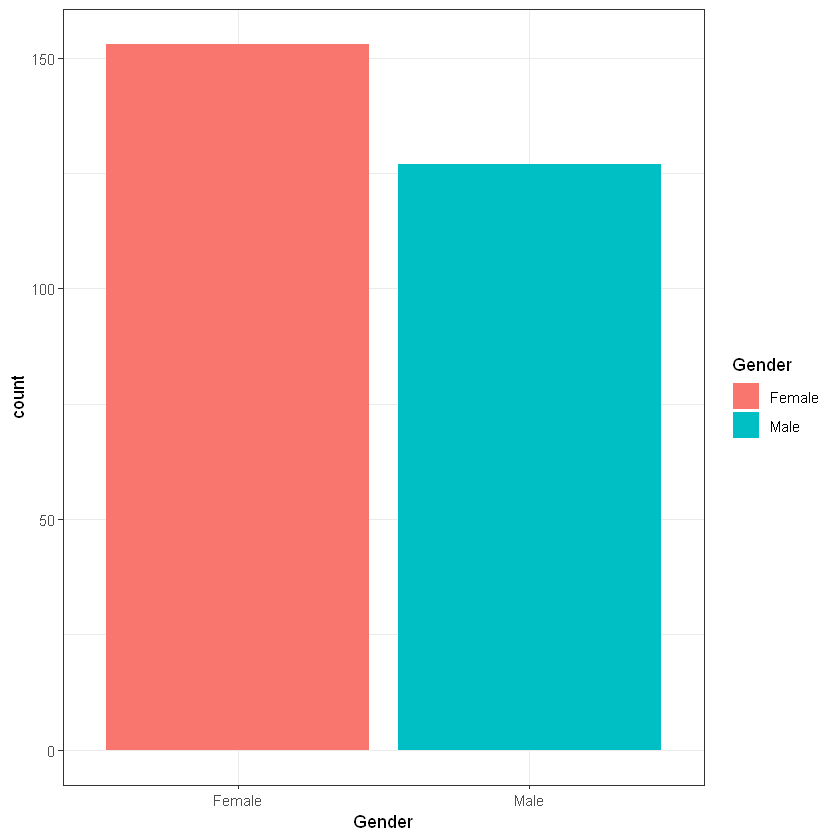

In [13]:
ggplot(train_data, aes(Gender)) + 
    geom_bar(aes(fill = Gender)) +
    theme_bw()

In [15]:
CrossTable(train_data$Gender)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  280 

 
          |    Female |      Male | 
          |-----------|-----------|
          |       153 |       127 | 
          |     0.546 |     0.454 | 
          |-----------|-----------|



 


In [16]:
CrossTable(test_data$Gender)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  120 

 
          |    Female |      Male | 
          |-----------|-----------|
          |        54 |        66 | 
          |     0.450 |     0.550 | 
          |-----------|-----------|



 


Сімейний стан (`Married`):

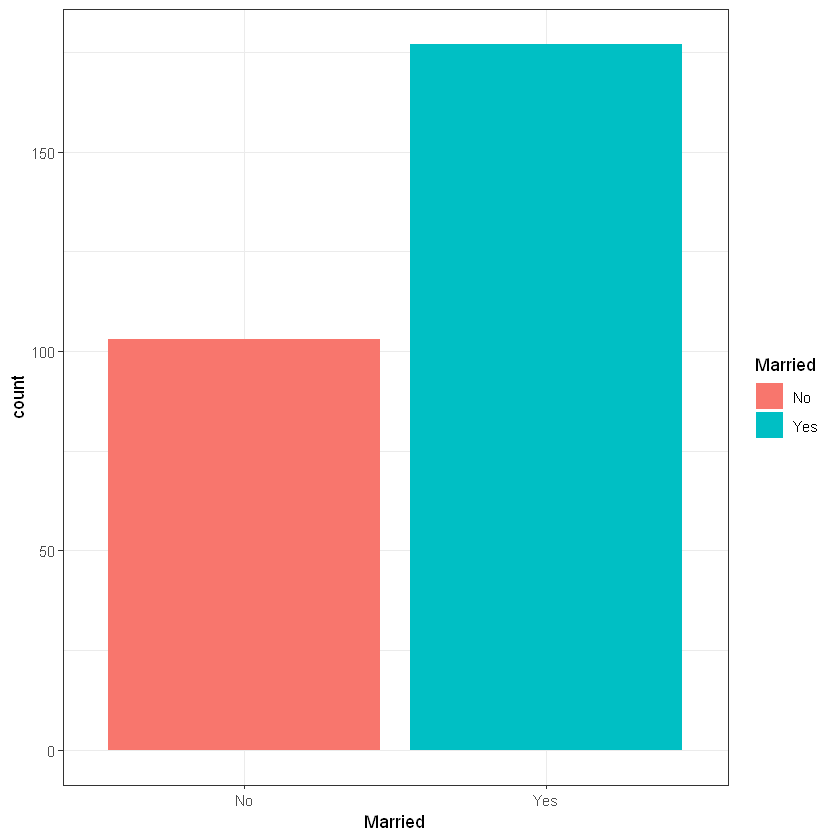

In [17]:
ggplot(train_data, aes(Married)) + geom_bar(aes(fill = Married)) + theme_bw()

In [15]:
CrossTable(train_data$Married)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  280 

 
          |        No |       Yes | 
          |-----------|-----------|
          |       101 |       179 | 
          |     0.361 |     0.639 | 
          |-----------|-----------|



 


Студент:

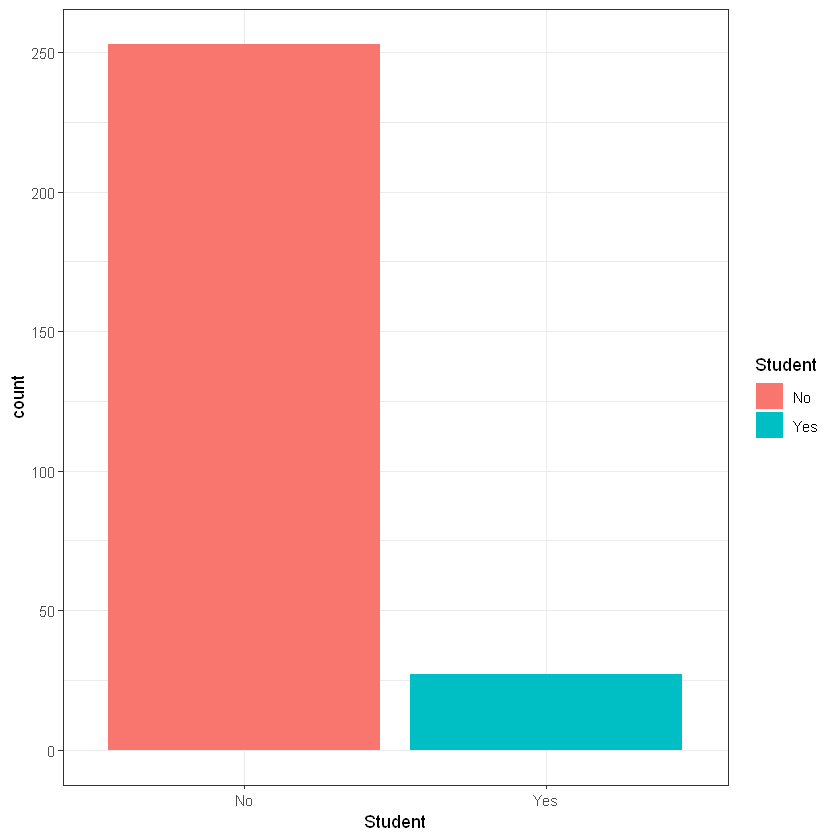

In [19]:
ggplot(train_data, aes(Student)) + geom_bar(aes(fill = Student)) + theme_bw()

In [17]:
CrossTable(train_data$Student)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  280 

 
          |        No |       Yes | 
          |-----------|-----------|
          |       255 |        25 | 
          |     0.911 |     0.089 | 
          |-----------|-----------|



 


Етнічна належність:

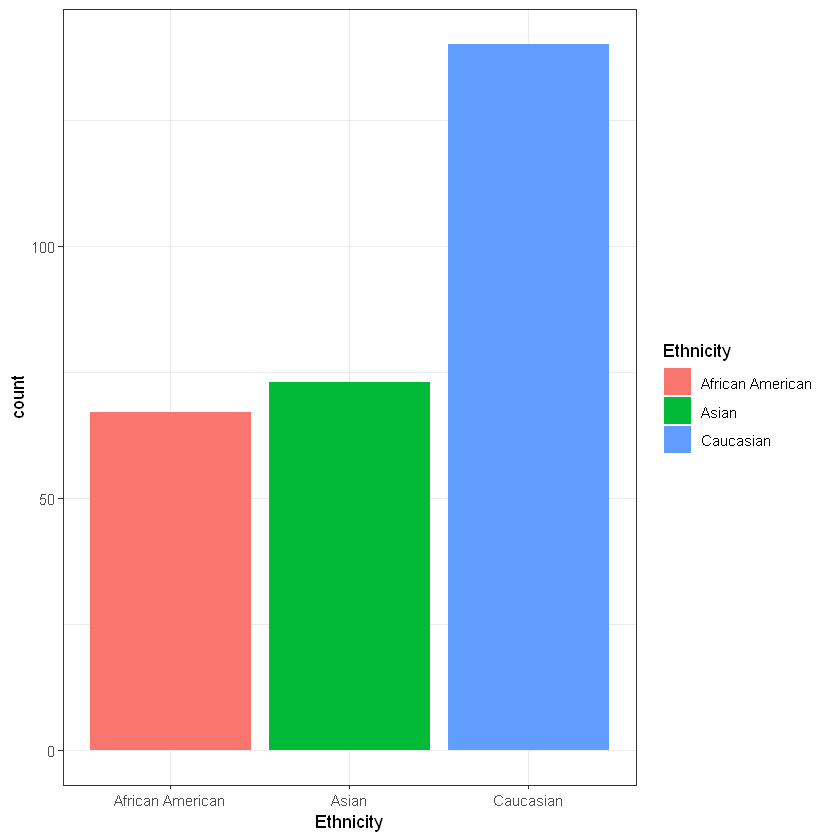

In [20]:
ggplot(train_data, aes(Ethnicity)) + geom_bar(aes(fill = Ethnicity)) + theme_bw()

In [21]:
CrossTable(train_data$Ethnicity)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  280 

 
                 | African American |            Asian |        Caucasian | 
                 |------------------|------------------|------------------|
                 |               67 |               73 |              140 | 
                 |            0.239 |            0.261 |            0.500 | 
                 |------------------|------------------|------------------|



 


Порівняємо числові змінні з показником середнього балансу.

Графік залежності між доходом (`Income`) та середнім балансом по карті (`Balance`):

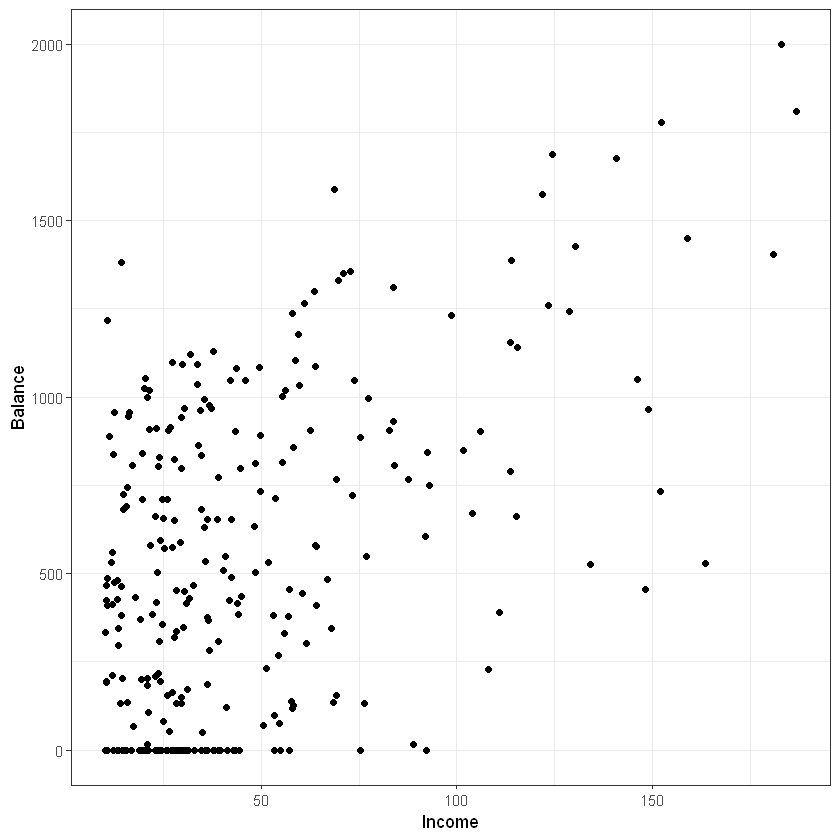

In [20]:
ggplot(train_data, aes(Income, Balance)) + geom_point()  + theme_bw()

Графік залежності між доходом (`Rating`) та середнім балансом по карті (`Balance`):

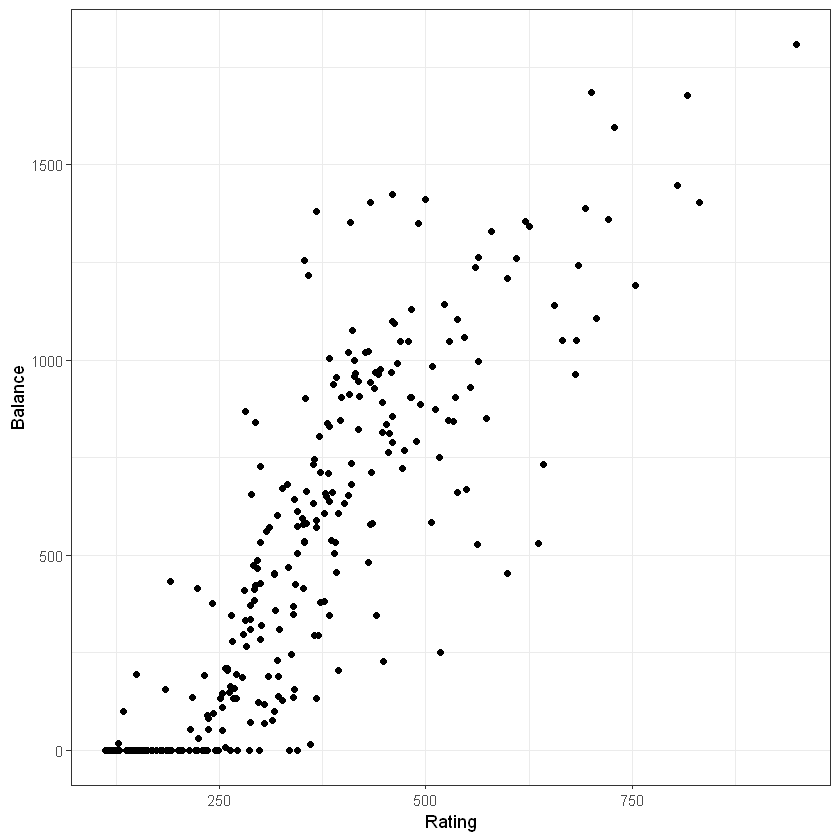

In [22]:
ggplot(train_data, aes(Rating, Balance)) + geom_point()  + theme_bw()

Графік залежності між кількістю карт (`Cards`) та середнім балансом по карті (`Balance`):

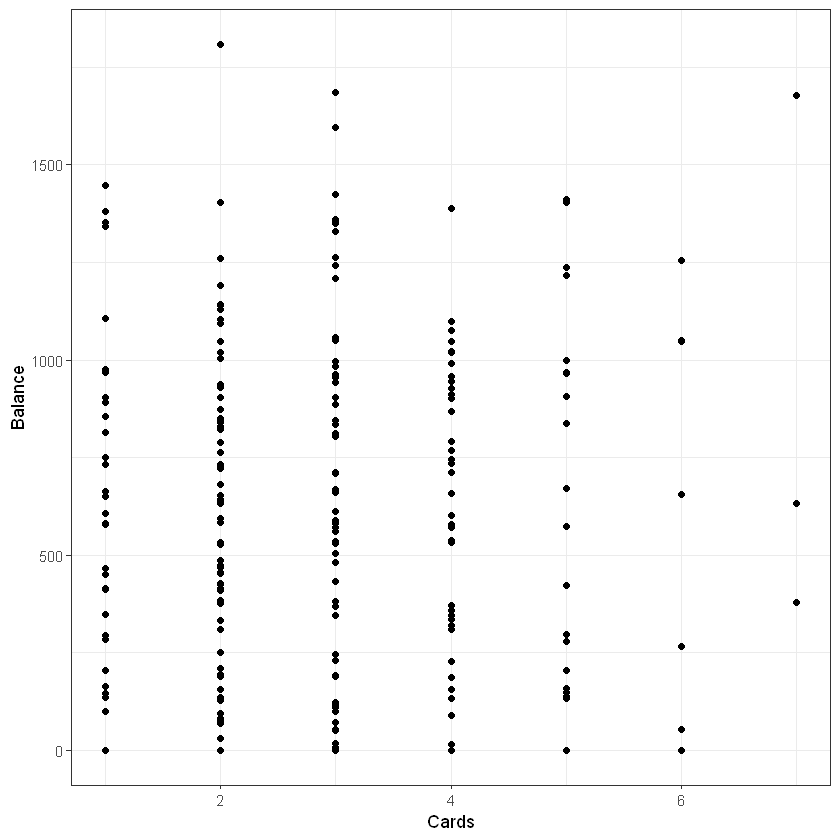

In [23]:
ggplot(train_data, aes(Cards, Balance)) + geom_point()  + theme_bw()

Графік залежності між віком (`Age`) та середнім балансом по карті (`Balance`):

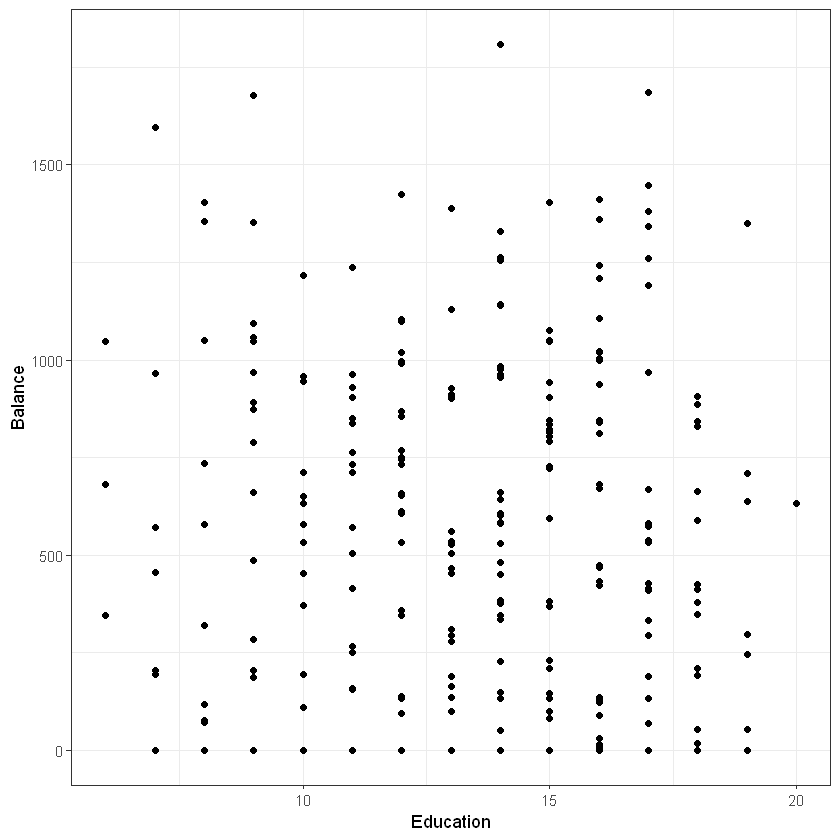

In [24]:
ggplot(train_data, aes(Education, Balance)) + geom_point()  + theme_bw()

Графік розподілу значень балансу:

---

## Моделювання. Робота з пакетом RPart

### Побудова моделі без налаштувань

Для побудови регресії на основі дерева рішень інсталюємо пакет `rpart` (`install.package("rpart")`).

Використаємо функцію для побудови моделі `rpart()`:


In [63]:
library(rpart)
rpart_model <- rpart(Balance ~ ., train_data)

In [64]:
lm_model <- lm(Balance ~ ., train_data)
summary(lm_model)


Call:
lm(formula = Balance ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-154.59  -76.54  -11.13   55.57  307.26 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -481.03594   40.89391 -11.763  < 2e-16 ***
Income               -7.65261    0.27583 -27.744  < 2e-16 ***
Limit                 0.19044    0.03935   4.839 2.21e-06 ***
Rating                1.13214    0.58821   1.925  0.05532 .  
Cards                15.26241    5.11480   2.984  0.00311 ** 
Age                  -0.66469    0.35430  -1.876  0.06174 .  
Education            -2.03425    1.92290  -1.058  0.29105    
GenderMale           20.90393   11.78121   1.774  0.07714 .  
StudentYes          415.40583   20.92348  19.854  < 2e-16 ***
MarriedYes           -1.09202   12.62022  -0.087  0.93111    
EthnicityAsian       33.09464   17.61564   1.879  0.06137 .  
EthnicityCaucasian    9.56019   14.49721   0.659  0.51017    
---
Signif. codes:  0 '***' 0.001

In [65]:
rpart_model

n= 280 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 280 57583030.00  529.62500  
   2) Rating< 353.5 144  7048396.00  188.85420  
     4) Rating< 278.5 88  1084105.00   64.26136 *
     5) Rating>=278.5 56  2451575.00  384.64290  
      10) Income>=47.8385 11    45162.18  104.27270 *
      11) Income< 47.8385 45  1330365.00  453.17780 *
   3) Rating>=353.5 136 16107060.00  890.44120  
     6) Rating< 683.5 125  9824622.00  829.32800  
      12) Limit< 5326.5 39  2022419.00  605.41030  
        24) Income>=48.3975 12   243564.90  352.58330 *
        25) Income< 48.3975 27   670882.70  717.77780 *
      13) Limit>=5326.5 86  4960012.00  930.87210  
        26) Income>=83.9085 22  1584143.00  786.31820 *
        27) Income< 83.9085 64  2758136.00  980.56250  
          54) Limit< 6621.5 41  1167789.00  891.97560 *
          55) Limit>=6621.5 23   695033.70 1138.47800 *
     7) Rating>=683.5 11   510442.90 1584.90900 *

Створимо дата-фрейми для запису результатів моделювання на тестовій та тренувальній вибірках:

In [66]:
train_res <- data.frame(No = c(1:nrow(train_data)), 
                        Balance = train_data$Balance, 
                        RPartPredicted = predict(rpart_model, train_data))

test_res <- data.frame(No = c(1:nrow(test_data)),
                       Balance = test_data$Balance, 
                       RPartPredicted = predict(rpart_model, test_data))

head(train_res)

,No,Balance,RPartPredicted
,<int>,<int>,<dbl>
373,1,840,453.17778
361,2,712,891.97561
243,3,16,64.26136
282,4,0,64.26136
44,5,976,891.97561
354,6,425,453.17778


### Оцінка метрик

Переглянемо похибки моделі на обох вибірках:

In [67]:
library(DMwR)
regr.eval(train_res$Balance, train_res$RPartPredicted)
regr.eval(test_res$Balance, test_res$RPartPredicted)

mae        mse       rmse       mape 
  119.6893 26183.8847   161.8144        Inf

mae        mse       rmse       mape 
  159.6746 49034.8929   221.4382        Inf

Оцінимо точність моделі за допомогою коефіцієнта детермінації:

In [68]:
r_train <- cor(train_res$Balance, train_res$RPartPredicted)^2
r_test <- cor(test_res$Balance, test_res$RPartPredicted)^2
print(paste("R_train = ", r_train, sep = ""))
print(paste("R_test = ", r_test, sep = ""))

[1] "R_train = 0.872679719680806"
[1] "R_test = 0.780363587175022"


In [69]:
r_train <- cor(train_res$Balance, predict(lm_model, train_data))^2
r_test <- cor(test_res$Balance, predict(lm_model, test_data))^2
print(paste("R_train = ", r_train, sep = ""))
print(paste("R_test = ", r_test, sep = ""))

[1] "R_train = 0.955910835214252"
[1] "R_test = 0.951178315668819"


Для покращення візуалізації відсортуємо результати:

In [70]:
# відсортуємо за зростанням значення балансів карт
ordered_train_res <- train_res[order(train_res$Balance),]
# відсортуємо за зростанням значення модельованого значення балансу
ordered_train_res <- train_res[order(train_res$RPartPredicted),]
# "Перепишемо" номери по порядку
ordered_train_res$No <- c(1:nrow(train_res))

In [44]:
head(ordered_train_res)

,No,Balance,RPartPredicted
,<int>,<int>,<dbl>
149,1,0,60.66279
338,2,0,60.66279
336,3,194,60.66279
188,4,0,60.66279
21,5,89,60.66279
56,6,0,60.66279


In [45]:
tail(ordered_train_res)

,No,Balance,RPartPredicted
,<int>,<int>,<dbl>
29,275,1809,1446.727
365,276,1243,1446.727
67,277,1388,1446.727
185,278,1448,1446.727
340,279,1107,1446.727
140,280,1597,1446.727


Побудуємо графік модельованих та реальних значень балансу з відсортованими показниками для наочності:

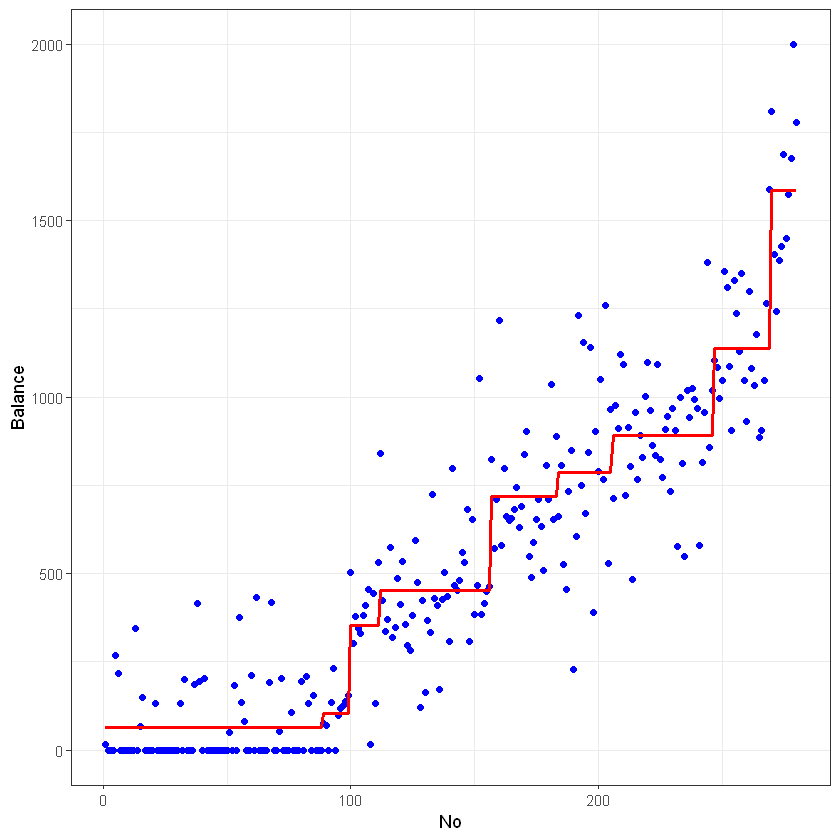

In [71]:
ggplot(ordered_train_res) +
  geom_point(aes(x = No, y = Balance), colour = "blue") +
  geom_line(aes(x = No, y = RPartPredicted), colour = "red", size = 1) + theme_bw()

Переглянемо залежність між рейтингом та балансом клієнта, а також прогнозованих значеннях.

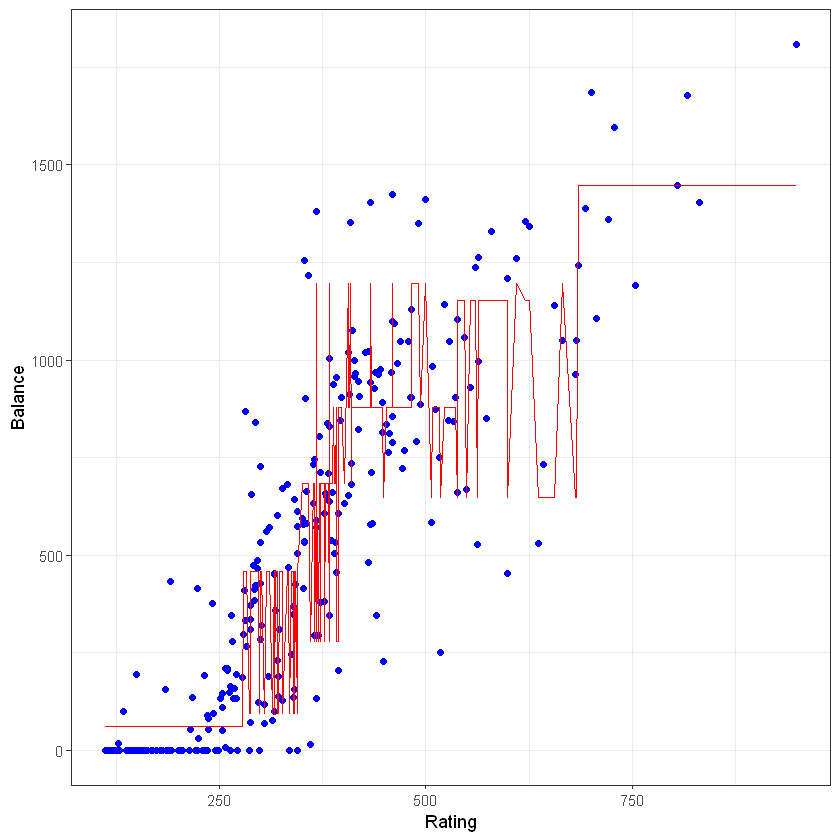

In [48]:
ggplot(train_data) +
  geom_point(aes(x = Rating, y = Balance), colour = "blue") +
  geom_line(aes(x = Rating, y = train_res$RPartPredicted), colour = "red") + theme_bw()

### Візуальне представлення

Для візуалізації дерева рішень скористаємося пакетом `rpart.plot`:

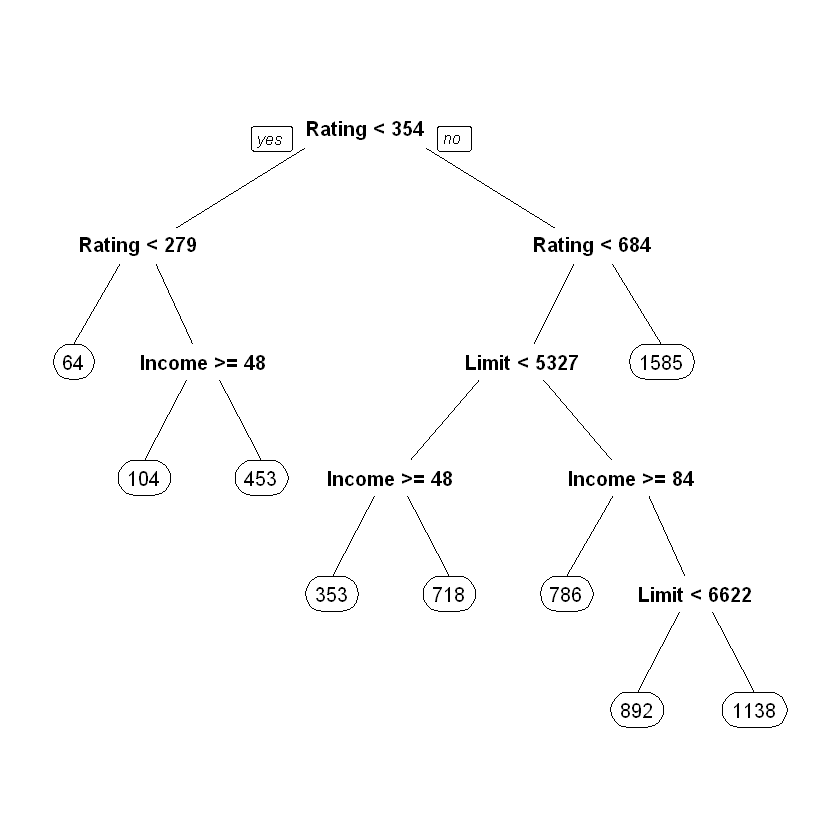

In [72]:
library(rpart.plot)
prp(rpart_model)

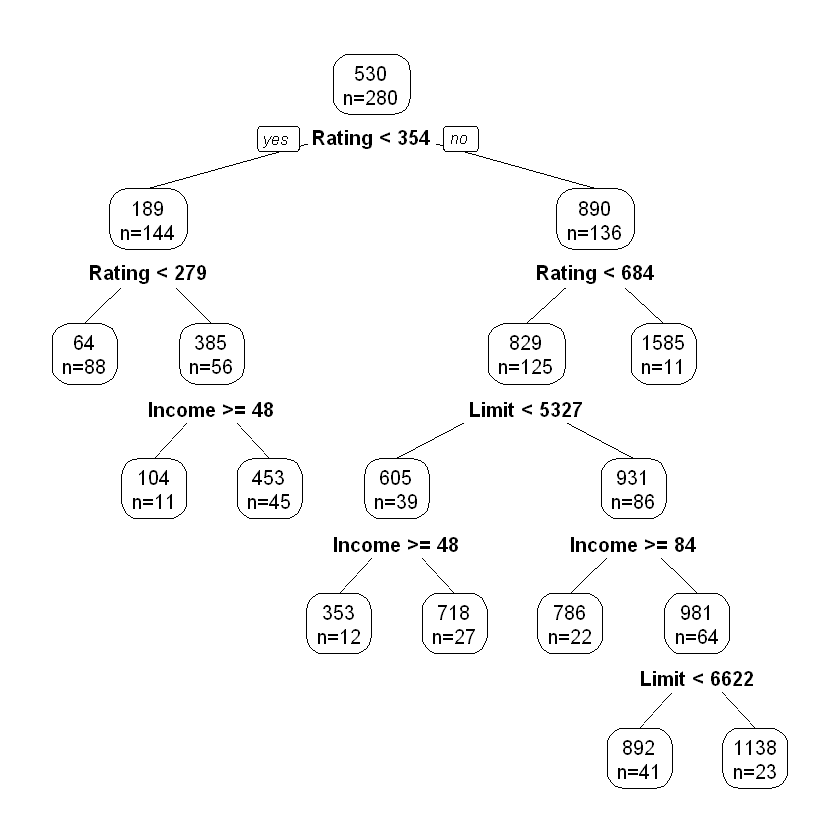

In [73]:
prp(rpart_model, extra = 1, type = 2)

Додамо інтерактивності для побудованого дерева рішень:

Warning message:
"ignoring snip=TRUE for png device"


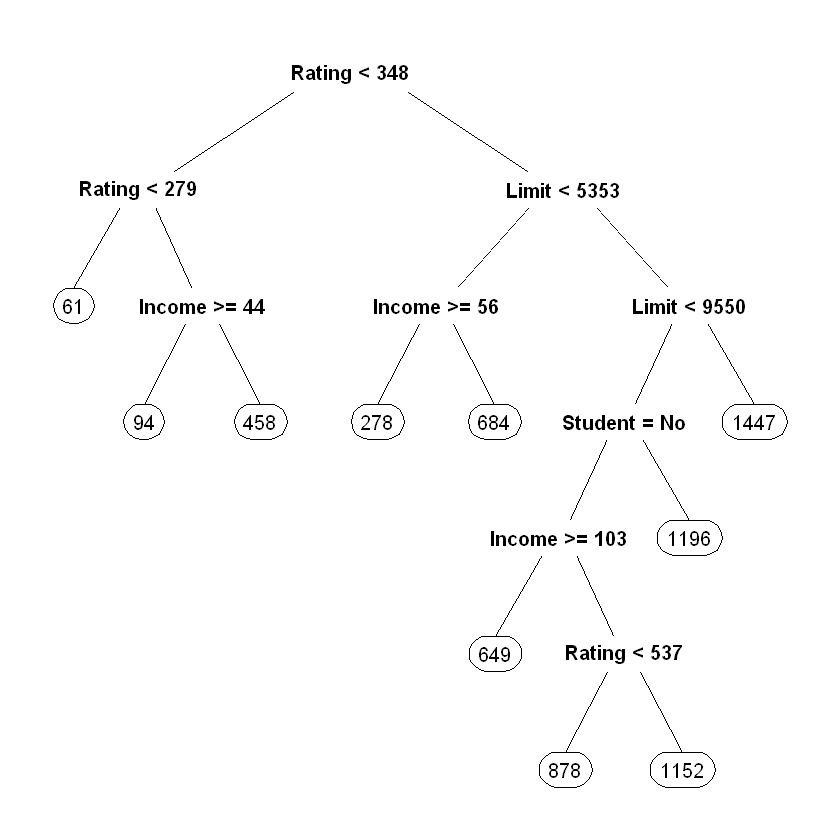

In [51]:
prp(rpart_model, snip = TRUE) # Працює у RStudio

Побудуємо також “розфарбоване” дерево рішень за допомогою пакетів `rattle` та `RColorBrewer`:

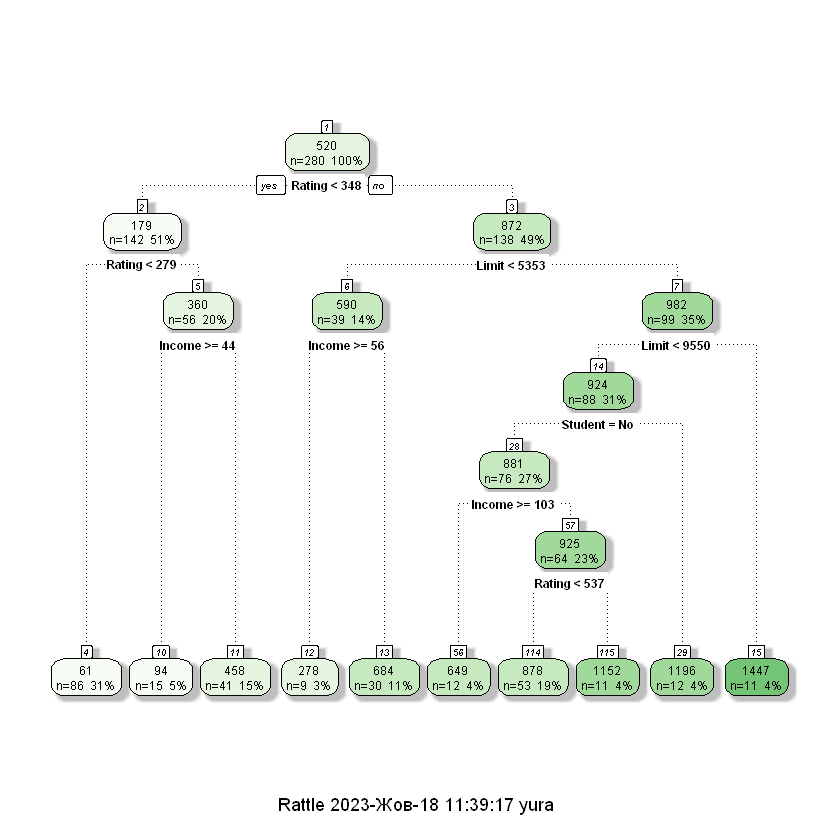

In [54]:
library(rattle)
library(RColorBrewer)
fancyRpartPlot(rpart_model)

---

### Побудова моделі з розділеннями

Побудуємо модель з вказанням мінімальної кількості розділень даних (`minsplit`):

In [76]:
rpart_model2 <- rpart(Balance ~ ., train_data, control = rpart.control(minsplit = 10))

Отримаємо прогнозовані значення для обох вибірок на основі другої моделі:

In [77]:
train_res$RPartPredicted10 <- predict(rpart_model2, train_data)
test_res$RPartPredicted10 <- predict(rpart_model2, test_data)

head(train_res)

,No,Balance,RPartPredicted,RPartPredicted10
,<int>,<int>,<dbl>,<dbl>
373,1,840,453.17778,836.25000
361,2,712,891.97561,891.97561
243,3,16,64.26136,64.26136
282,4,0,64.26136,64.26136
44,5,976,891.97561,891.97561
354,6,425,453.17778,415.80488


### Оцінка метрик

Переглянемо похибки:

In [78]:
regr.eval(train_res$Balance, train_res$RPartPredicted10)
regr.eval(test_res$Balance, test_res$RPartPredicted10)

mae        mse       rmse       mape 
  115.0021 23883.0155   154.5413        Inf

mae        mse       rmse       mape 
  152.5249 43219.8820   207.8939        Inf

Оцінимо точність моделі за допомогою коефіцієнта детермінації:

In [79]:
r_train <- cor(train_res$Balance, train_res$RPartPredicted10)^2
r_test <- cor(test_res$Balance, test_res$RPartPredicted10)^2

print(paste("R_train =", r_train, sep = ""))
print(paste("R_test =", r_test, sep = ""))

[1] "R_train =0.883867796629392"
[1] "R_test =0.805983358303455"


### Візуалізація результатів

Візуалізуємо модель:

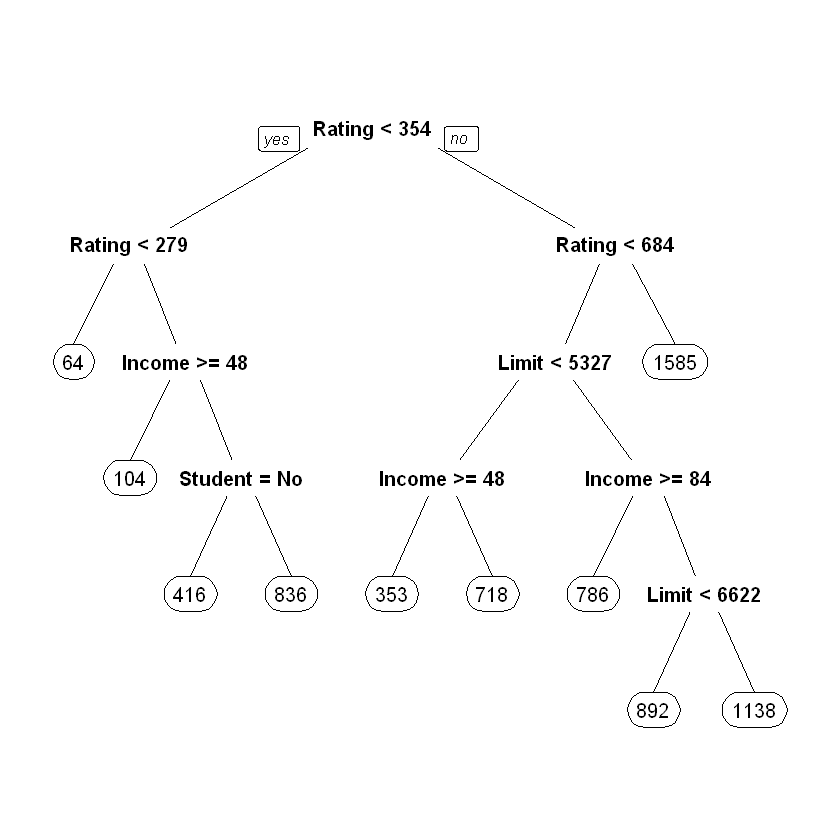

In [80]:
prp(rpart_model2)

---

## Моделювання. Робота з пакетом `partykit`

Побудуємо дерево рішень на основі `partykit` та функції `ctree()` та порівняємо з результатами роботи `rpart()`.

In [82]:
library(partykit)
party_model <- ctree(Balance ~ ., data = train_data[1:100,]) # перших 100 спостережень
print(party_model)


Model formula:
Balance ~ Income + Limit + Rating + Cards + Age + Education + 
    Gender + Student + Married + Ethnicity

Fitted party:
[1] root
|   [2] Rating <= 342
|   |   [3] Rating <= 245: 3.360 (n = 25, err = 4597.8)
|   |   [4] Rating > 245
|   |   |   [5] Income <= 19.782: 416.200 (n = 10, err = 290573.6)
|   |   |   [6] Income > 19.782: 221.889 (n = 18, err = 254079.8)
|   [7] Rating > 342
|   |   [8] Rating <= 599: 765.051 (n = 39, err = 1913599.9)
|   |   [9] Rating > 599: 1380.625 (n = 8, err = 720389.9)

Number of inner nodes:    4
Number of terminal nodes: 5


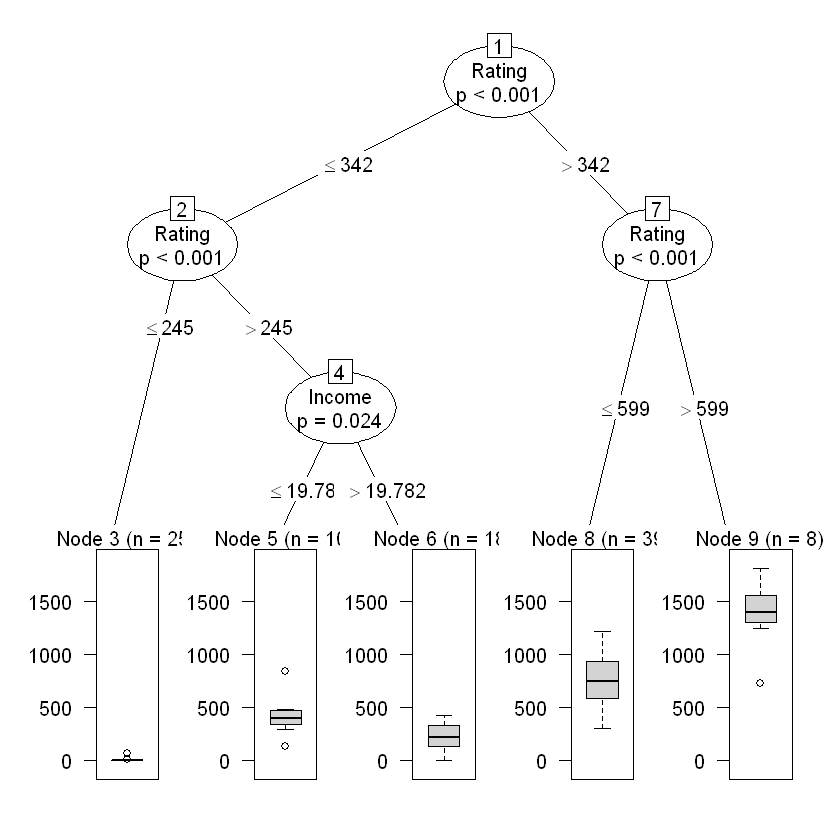

In [83]:
plot(party_model)

In [84]:
party_model <- ctree(Balance ~ ., data = train_data) 
print(party_model)


Model formula:
Balance ~ Income + Limit + Rating + Cards + Age + Education + 
    Gender + Student + Married + Ethnicity

Fitted party:
[1] root
|   [2] Rating <= 353
|   |   [3] Rating <= 278
|   |   |   [4] Student in No
|   |   |   |   [5] Rating <= 249: 8.516 (n = 62, err = 64369.5)
|   |   |   |   [6] Rating > 249: 167.056 (n = 18, err = 91486.9)
|   |   |   [7] Student in Yes: 265.000 (n = 8, err = 223014.0)
|   |   [8] Rating > 278
|   |   |   [9] Income <= 44.978: 453.178 (n = 45, err = 1330364.6)
|   |   |   [10] Income > 44.978: 104.273 (n = 11, err = 45162.2)
|   [11] Rating > 353
|   |   [12] Rating <= 682
|   |   |   [13] Limit <= 5310
|   |   |   |   [14] Income <= 48.218: 717.778 (n = 27, err = 670882.7)
|   |   |   |   [15] Income > 48.218: 352.583 (n = 12, err = 243564.9)
|   |   |   [16] Limit > 5310
|   |   |   |   [17] Student in No
|   |   |   |   |   [18] Income <= 101.788
|   |   |   |   |   |   [19] Rating <= 536
|   |   |   |   |   |   |   [20] Income <= 63.80

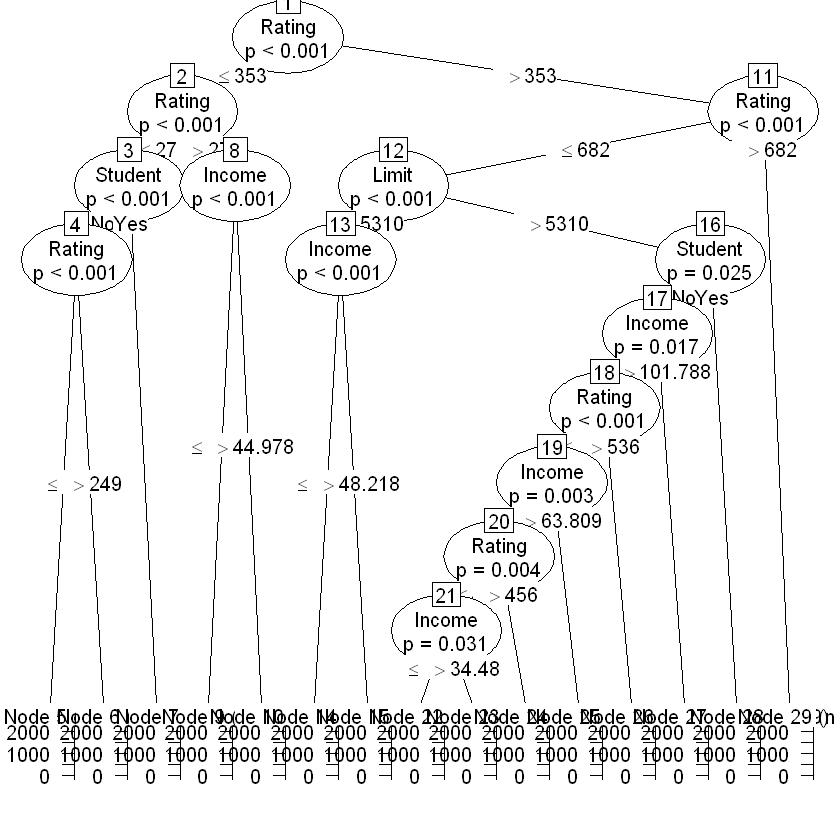

In [85]:
plot(party_model)

Обчислимо модельовані значення середнього балансу по карті:

In [86]:
train_res$PredictedParty <- predict(party_model, train_data)
test_res$PredictedParty <- predict(party_model, test_data)

Переглянемо коефіцієнти детермінації:

In [87]:
r_train <- cor(train_res$Balance, train_res$PredictedParty)^2
r_test <- cor(test_res$Balance, test_res$PredictedParty)^2

print(paste("R_train = ", r_train, sep = ""))
print(paste("R_test = ", r_test, sep = ""))

[1] "R_train = 0.906079382030953"
[1] "R_test = 0.857313458113989"


---